In [1]:
# Adding needed libraries and reading data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('/home/suyog/github/House-Prices-Advanced-Regression-Techniques/train.csv')
test = pd.read_csv('/home/suyog/github/House-Prices-Advanced-Regression-Techniques/test.csv')


In [2]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
#Checking for missing data
NAs = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs[NAs.sum(axis=1) > 0]

,Train,Test
Alley,1369,1352.0
BsmtCond,37,45.0
BsmtExposure,38,44.0
BsmtFinSF1,0,1.0
BsmtFinSF2,0,1.0
BsmtFinType1,37,42.0
BsmtFinType2,38,42.0
BsmtFullBath,0,2.0
BsmtHalfBath,0,2.0
BsmtQual,37,44.0


In [4]:
# Prints R2 and RMSE scores
def get_score(prediction, lables):    
    print('R2: {}'.format(r2_score(prediction, lables)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction, lables))))

# Shows scores for train and validation sets    
def train_test(estimator, x_trn, x_tst, y_trn, y_tst):
    prediction_train = estimator.predict(x_trn)
    # Printing estimator
    print(estimator)
    # Printing train scores
    get_score(prediction_train, y_trn)
    prediction_test = estimator.predict(x_tst)
    # Printing test scores
    print("Test")
    get_score(prediction_test, y_tst)

In [5]:
# Spliting to features and lables and deleting variable I don't need
train_labels = train.pop('SalePrice')

features = pd.concat([train, test], keys=['train', 'test'])

# I decided to get rid of features that have more than half of missing information or do not correlate to SalePrice
features.drop(['Utilities', 'RoofMatl', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'LowQualFinSF',
               'BsmtFullBath', 'BsmtHalfBath', 'Functional', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'WoodDeckSF',
               'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal'],
              axis=1, inplace=True)

In [6]:
#Filling NAs and converting features

# MSSubClass as str
features['MSSubClass'] = features['MSSubClass'].astype(str)

# MSZoning NA in pred. filling with most popular values
features['MSZoning'] = features['MSZoning'].fillna(features['MSZoning'].mode()[0])

# LotFrontage  NA in all. I suppose NA means 0
features['LotFrontage'] = features['LotFrontage'].fillna(features['LotFrontage'].mean())

# Alley  NA in all. NA means no access
features['Alley'] = features['Alley'].fillna('NOACCESS')

# Converting OverallCond to str
features.OverallCond = features.OverallCond.astype(str)

# MasVnrType NA in all. filling with most popular values
features['MasVnrType'] = features['MasVnrType'].fillna(features['MasVnrType'].mode()[0])

# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2
# NA in all. NA means No basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('NoBSMT')

# TotalBsmtSF  NA in pred. I suppose NA means 0
features['TotalBsmtSF'] = features['TotalBsmtSF'].fillna(0)

# Electrical NA in pred. filling with most popular values
features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])

# KitchenAbvGr to categorical
features['KitchenAbvGr'] = features['KitchenAbvGr'].astype(str)

# KitchenQual NA in pred. filling with most popular values
features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])

# FireplaceQu  NA in all. NA means No Fireplace
features['FireplaceQu'] = features['FireplaceQu'].fillna('NoFP')

# GarageType, GarageFinish, GarageQual  NA in all. NA means No Garage
for col in ('GarageType', 'GarageFinish', 'GarageQual'):
    features[col] = features[col].fillna('NoGRG')

# GarageCars  NA in pred. I suppose NA means 0
features['GarageCars'] = features['GarageCars'].fillna(0.0)

# SaleType NA in pred. filling with most popular values
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

# Year and Month to categorical
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

# Adding total sqfootage feature and removing Basement, 1st and 2nd floor features
features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
features.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)

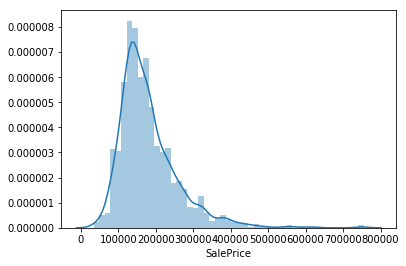

In [7]:
#Log Transformation
# Our SalesPrice is skewed right (check plot below). I'm logtransforming it. 
ax = sns.distplot(train_labels)

In [8]:
## Log transformation of labels
train_labels = np.log(train_labels)

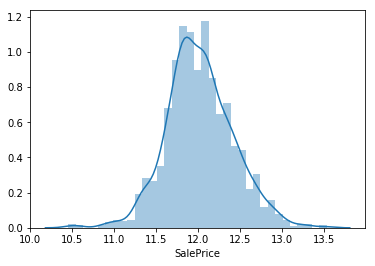

In [9]:
## Now it looks much better
ax = sns.distplot(train_labels)

In [10]:
## Standardizing numeric features
numeric_features = features.loc[:,['LotFrontage', 'LotArea', 'GrLivArea', 'TotalSF']]
numeric_features_standardized = (numeric_features - numeric_features.mean())/numeric_features.std()

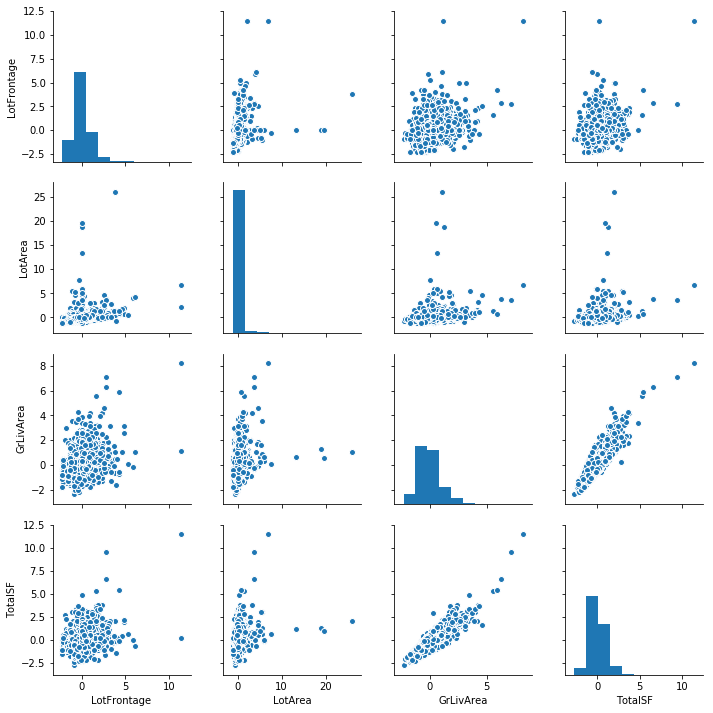

In [11]:
ax = sns.pairplot(numeric_features_standardized)

In [12]:
#Converting categorical data to dummies

# Getting Dummies from Condition1 and Condition2
conditions = set([x for x in features['Condition1']] + [x for x in features['Condition2']])
dummies = pd.DataFrame(data=np.zeros((len(features.index), len(conditions))),
                       index=features.index, columns=conditions)
for i, cond in enumerate(zip(features['Condition1'], features['Condition2'])):
    dummies.ix[i, cond] = 1
features = pd.concat([features, dummies.add_prefix('Condition_')], axis=1)
features.drop(['Condition1', 'Condition2'], axis=1, inplace=True)

# Getting Dummies from Exterior1st and Exterior2nd
exteriors = set([x for x in features['Exterior1st']] + [x for x in features['Exterior2nd']])
dummies = pd.DataFrame(data=np.zeros((len(features.index), len(exteriors))),
                       index=features.index, columns=exteriors)
for i, ext in enumerate(zip(features['Exterior1st'], features['Exterior2nd'])):
    dummies.ix[i, ext] = 1
features = pd.concat([features, dummies.add_prefix('Exterior_')], axis=1)
features.drop(['Exterior1st', 'Exterior2nd', 'Exterior_nan'], axis=1, inplace=True)

# Getting Dummies from all other categorical vars
for col in features.dtypes[features.dtypes == 'object'].index:
    for_dummy = features.pop(col)
    features = pd.concat([features, pd.get_dummies(for_dummy, prefix=col)], axis=1)